# Intersection of the flowpipe with an invariant: INT algorithm

In [6]:
using Revise, LazySets, BenchmarkTools, InteractiveUtils, Test
using ReachabilityAnalysis

## The invariant is an interval

In [7]:
x = rand(Interval)
y = rand(Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.117879, 0.960433])

The implementation in LazySets is efficient does not have inference problems.

In [3]:
@btime is_intersection_empty($x, $y)

  0.016 ns (0 allocations: 0 bytes)


false

In [4]:
@inferred is_intersection_empty(x, y)

false

If the function is called with the third argument, `witness`, there are problems though, as shown below, but we are not interested in that use case. That can probably be fixed by dispatching on values.

In [34]:
@inferred is_intersection_empty(x, y, true)

ErrorException: return type Tuple{Bool,Array{Float64,1}} does not match inferred return type Union{Bool, Tuple{Bool,Array{Float64,1}}}

The implementation in LazySets is the following one:

```julia
function is_intersection_empty(I1::Interval{N}, I2::Interval{N},
                               witness::Bool=false) where {N<:Real}
    check = min(I2) > max(I1) || min(I1) > max(I2)
    if !witness
        return check
    else
        return (check, [max(min(I1), min(I2))])
    end
end
```

The problem with this implementation is that it ignores the tolerance defined within LazySets.

The following example illustrates this problem:

In [40]:
x = Interval(0.0, 1.0 - 1e-10)
y = Interval(1.0, 2.0)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([1, 2])

In [41]:
is_intersection_empty(x, y)

true

Although the default relative tolerance is bigger:

In [33]:
LazySets._rtol(Float64)

1.4901161193847656e-8

So the fix is to the comparison functions from LazySets.jl. We should be careful about how to descibe the constraint $x > y$ in terms of the robust functions. The latter are not strict, hence the correct transformation is:

- $x > y$ iff $!(x \leq y)$

In [59]:
using LazySets: _leq, _geq

function _is_intersection_empty(I1::Interval{N}, I2::Interval{N}) where {N<:Real}
    return !_leq(min(I2), max(I1)) || !_leq(min(I1), max(I2))
end

_is_intersection_empty (generic function with 1 method)

In [60]:
_is_intersection_empty(x, y)

false

In [61]:
@inferred _is_intersection_empty(x, y) # no inference problems

false

There is some small overhead in using the robust comparisons functions though,

In [62]:
@btime _is_intersection_empty($x, $y) # not "0" but still fast

  5.882 ns (0 allocations: 0 bytes)


false

But we get consistency with respect to the prescribed tolerance. See how changing the tolerance makes the intersection empty now.

In [67]:
LazySets.set_rtol(Float64, 1e-12)

1.0e-12

In [69]:
_is_intersection_empty(x, y)

true

In [80]:
# let's restore the default tolerance
LazySets.set_rtol(Float64, LazySets.default_tolerance(Float64).rtol)

1.4901161193847656e-8

## The invariant is a half-space

**Note.** Consider the interval $X = [\alpha, \beta]$ and the half-space $H : \{x : ax \leq b\}$, with $a \in \mathbb{R} \setminus \{0\}$ and $b \in \mathbb{R}$. The intersection $X \cap H$ is empty if and only if:

- $a > 0$ and $\alpha > b/a$, or
- $a < 0$ and $\beta < b/a$.

In [70]:
H = HalfSpace([1.0], 0.0)  # x <= 0

HalfSpace{Float64,Array{Float64,1}}([1.0], 0.0)

For reference, the implementation with LazySets:

In [71]:
@which is_intersection_empty(x, h)

is_intersection_empty(P::AbstractPolyhedron{N}, hs::HalfSpace{N,VN} where VN<:AbstractArray{N,1}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/ConcreteOperations/isdisjoint.jl:997

In [86]:
@inferred is_intersection_empty(x, h)

ErrorException: return type Bool does not match inferred return type Union{Bool, Tuple{Bool,Array{Float64,1}}}

In [26]:
@btime is_intersection_empty($x, $h)

  35.264 ns (1 allocation: 96 bytes)


false

This implementation is not optimal in terms of efficiency, and it is also not robust as the following example shows.

In [93]:
is_intersection_empty(Interval(0.0, 1.0), HalfSpace([1.0], -1e-10))

true

In [94]:
LazySets._rtol(Float64)

1.4901161193847656e-8

In [153]:
# H : {x : ax <= b}, one-dimensional with a != 0
function _is_intersection_empty(X::Interval{N}, H::HalfSpace{N}) where {N<:Real}
    a = H.a[1]
    b = H.b
    if a > zero(N)
        return !_leq(min(X), b/a)
    else
        return !_geq(max(X), b/a)
    end
end

# symmetric case
_is_intersection_empty(H::HalfSpace, X::Interval) = _is_intersection_empty(X, H)

_is_intersection_empty (generic function with 5 methods)

In [112]:
x

Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 1])

In [113]:
h

HalfSpace{Float64,Array{Float64,1}}([1.0], 0.0)

In [114]:
@inferred _is_intersection_empty(x, h)

false

In [115]:
@btime _is_intersection_empty($x, $h)

  3.194 ns (0 allocations: 0 bytes)


false

In [116]:
x2 = Interval(0.0, 1.0)
h2 = HalfSpace([1.0], -1e-10)
_is_intersection_empty(x2, h2)

false

In [117]:
@btime _is_intersection_empty($x2, $h2)

  3.196 ns (0 allocations: 0 bytes)


false

In [118]:
LazySets.set_rtol(Float64, 1e-12)

1.0e-12

In [129]:
LazySets._rtol(Float64)

1.0e-12

In [124]:
_is_intersection_empty(x2, h2)

s


false

In [131]:
b_over_a = h2.b / first(h2.a)
min(x2), b_over_a

(0.0, -1.0e-10)

In [133]:
_leq(min(x2), b_over_a)

true

In [137]:
LazySets.set_atol(Float64, 1e-12)

1.0e-12

In [138]:
_leq(min(x2), b_over_a)

true

In [139]:
LazySets.set_ztol(Float64, 1e-12)

1.0e-12

In [140]:
_leq(min(x2), b_over_a)

false

In [143]:
_is_intersection_empty(x2, h2)

true

## The invariant is a hyperplane

**Note.** Consider the interval $X = [\alpha, \beta]$ and the half-space $H : \{x : ax = b\}$, with $a \in \mathbb{R} \setminus \{0\}$ and $b \in \mathbb{R}$. The intersection $X \cap H$ is empty if and only if:

- $b/a < \alpha$, or
- $b/a > \beta$

In [154]:
x

Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 1])

In [155]:
h = Hyperplane([1.0], 0.0) # x = 0.0

Hyperplane{Float64}([1.0], 0.0)

In [156]:
is_intersection_empty(x, h)

false

In [157]:
@btime is_intersection_empty($x, $h) # slow and allocating

  13.047 μs (92 allocations: 6.11 KiB)


false

In [158]:
@inferred is_intersection_empty(x, h)

ErrorException: return type Bool does not match inferred return type Any

In [159]:
@which is_intersection_empty(x, h)

is_intersection_empty(P::AbstractPolyhedron{N}, hp::Union{Hyperplane{N}, Line{N,VN} where VN<:AbstractArray{N,1}}) where N<:Real in LazySets at /home/mforets/.julia/dev/LazySets/src/ConcreteOperations/isdisjoint.jl:1031

In [187]:
# H : {x : ax = b}, one-dimensional with a != 0
function _is_intersection_empty(X::Interval{N}, H::Hyperplane{N}) where {N<:Real}
    q = H.b / H.a[1]
    return !_geq(q, min(X)) || !_leq(q, max(X))
end

# symmetric case
_is_intersection_empty(H::Hyperplane, X::Interval) = _is_intersection_empty(X, H)

_is_intersection_empty (generic function with 5 methods)

In [163]:
_is_intersection_empty(x, h)

false

In [189]:
@btime _is_intersection_empty($x, $h)

  31.964 ns (3 allocations: 48 bytes)


0.0

In [188]:
@inferred _is_intersection_empty(x, h)

ErrorException: return type Float64 does not match inferred return type Any

In [186]:
h.b

0.0

We can get a more efficient version using another representation of the halfspace. The correponding issue is https://github.com/JuliaReach/LazySets.jl/issues/2115 

In [190]:
struct Hyperplane2{N<:Real, VN<:AbstractVector{N}} <: LazySets.AbstractPolyhedron{N}
    a::VN
    b::N

    function Hyperplane2(a::VN, b::N) where {N<:Real, VN<:AbstractVector{N}}
        @assert !iszero(a) "a hyperplane needs a non-zero normal vector"
        return new{N, VN}(a, b)
    end
end

In [191]:
h

Hyperplane{Float64}([1.0], 0.0)

In [192]:
h2 = Hyperplane2([1.0], 0.0)

Hyperplane2{Float64,Array{Float64,1}}([1.0], 0.0)

In [193]:
# H : {x : ax = b}, one-dimensional with a != 0
function _is_intersection_empty(X::Interval{N}, H::Hyperplane2{N}) where {N<:Real}
    q = H.b / H.a[1]
    return !_geq(q, min(X)) || !_leq(q, max(X))
end

# symmetric case
_is_intersection_empty(H::Hyperplane2, X::Interval) = _is_intersection_empty(X, H)

_is_intersection_empty (generic function with 7 methods)

In [194]:
@inferred _is_intersection_empty(x, h2)

false

In [195]:
@btime _is_intersection_empty($x, $h2)

  3.192 ns (0 allocations: 0 bytes)


false

Fixing the inference problem, we get the same performance as for the half-space case: 0 allocations and < 5ns.

# Test

In [1]:
using Revise, LazySets, BenchmarkTools, InteractiveUtils, Test
using ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


In [2]:
include("/home/mforets/.julia/dev/ReachabilityAnalysis/test/models/linear/exponential1D.jl")

exponential_1d (generic function with 1 method)

In [60]:
prob, dt = exponential_1d()

(InitialValueProblem{ConstrainedLinearContinuousSystem{Float64,IdentityMultiple{Float64},Universe{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(ConstrainedLinearContinuousSystem{Float64,IdentityMultiple{Float64},Universe{Float64}}([-1.0], Universe{Float64}(1)), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.4, 0.5])), (0.0, 1.0))

In [61]:
sol = solve(prob, tspan=dt, INT(δ=0.01));

In [5]:
alg = INT(δ=0.01)
@btime solve($prob, tspan=$dt, alg=alg);

  2.250 μs (24 allocations: 5.11 KiB)


In [7]:
@inferred solve(prob, tspan=dt, INT(δ=0.01));

In [9]:
using Plots

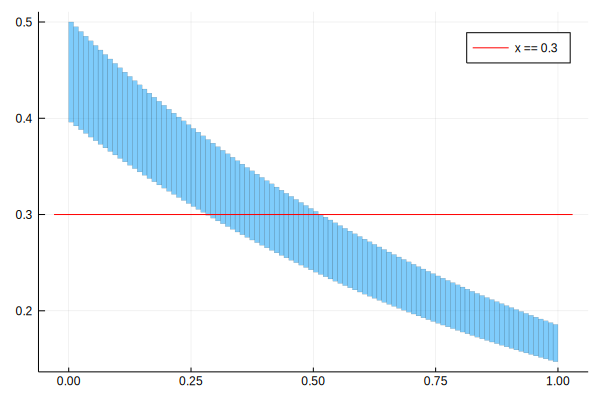

In [35]:
plot(sol, vars=(0, 1), lw=0.2)
plot!(x -> 0.3, color=:red, lab="x == 0.3")

In [62]:
X = HalfSpace([-1.0], -0.3) # x >= 0.3
prob, dt = exponential_1d(invariant=X)

(InitialValueProblem{ConstrainedLinearContinuousSystem{Float64,IdentityMultiple{Float64},HalfSpace{Float64,Array{Float64,1}}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(ConstrainedLinearContinuousSystem{Float64,IdentityMultiple{Float64},HalfSpace{Float64,Array{Float64,1}}}([-1.0], HalfSpace{Float64,Array{Float64,1}}([-1.0], -0.3)), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.4, 0.5])), (0.0, 1.0))

In [52]:
sol = solve(prob, tspan=dt, INT(δ=0.01));

In [40]:
@btime solve($prob, tspan=$dt, alg);

  1.669 μs (27 allocations: 5.31 KiB)


In [38]:
tspan(sol)

[0, 0.520001]

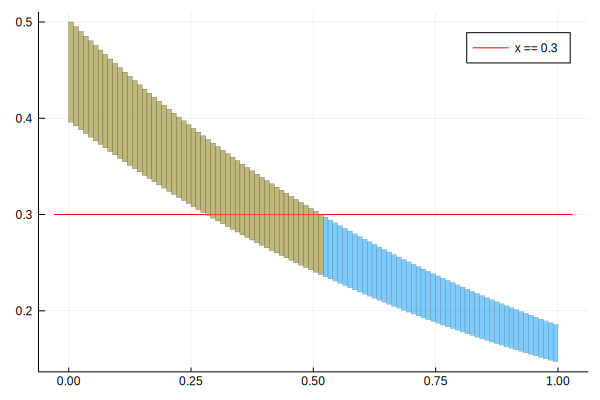

In [39]:
plot!(sol, vars=(0, 1), color=:orange, lw=0.2)

In [81]:
[0.3] ∈ sol_inv[end]

true

In [105]:
sol_inv[52]

ReachSet{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.237793, 0.300248]), [0.509999, 0.520001])

In [106]:
sol_in]

52

In [82]:
sol_inv = solve(prob, tspan=dt, INT(δ=0.01));

In [109]:
[0.3] ∈ sol[52] && [0.3] ∉ sol[53]

true

In [102]:
[0.3] ∈ sol[52]

true